In [94]:
%load_ext autoreload
%autoreload 2
import numpy as np
import numpy.ma as ma
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as ticker
import matplotlib.dates as dates
from mpl_toolkits.axes_grid1 import ImageGrid,make_axes_locatable,host_subplot
from mpl_toolkits.basemap import Basemap
from datetime import datetime, timedelta
import pytz as pytz
import sys
import os
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
import modules.utils as utils
import modules.thermolib as thermo
import modules.DSDlib as dsd
import modules.disdrometer_module as dis
import modules.plotmodule as PIPSplot
from modules.datahandler import getDataHandler
import pandas as pd
import glob
import numpy.random as random
from scipy.stats import gamma, uniform
from scipy.special import gamma as gammafunc
from scipy import ndimage
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [148]:
# Function definitions
def gammaDSD(D, cx,q ,Nt=None, N0=None, alpha=0):
    """Given cx, q, Nt or N0, and alpha, compute the gamma DSD for the sequence of diameters in D"""
    if(N0 is None):
        try:
            N0,_ = dsd.cal_N0(rhoa, q/1000., Nt, cx, alpha)
        except Exception:
            return None
    else:
        try:
            Nt = dsd.cal_Nt(rhoa, q/1000., N0, cx, alpha)
        except Exception:
            return None
        
    lamda = dsd.cal_lamda(rhoa, q/1000., Nt, cx, alpha)
    
    return N0*D**alpha*np.exp(-lamda*D), Nt, lamda, alpha

def samplegammaDSD(Nt, lamda, alpha, bins=None):
    """Randomly samples a gamma DSD given Nt, lamda, and alpha."""
    scale = 1./lamda
    shape = alpha+1.
    s = gamma.rvs(shape, scale=scale, size=int(Nt))
    # If desired, bin up the resulting samples into the given diameter ranges
    if(bins is None):
        return s
    else:
        ND_sample,_ = np.histogram(s, bins)
        return ND_sample/(bins[1:]-bins[:-1])

def plotDSD(Dl, Dmid, Dr, ND, ax=None):
    """Plots a DSD on a semilog plot"""
    if ax is None:
        fig = plt.figure(figsize=(8,6))
        ax = fig.add_subplot(111)
    ax.bar(Dl, ND, Dr-Dl, 10.**2., align='edge', log=True, color='tan', edgecolor = 'k')
    ax.set_yscale('log')
    ax.set_ylim(10.**2., 10.**8.5)
    ax.set_xlim(0., 9.)
    ax.set_xlabel('D (mm)')
    ax.set_ylabel(r'N(D) $(m^{-4})$')
    
    return ax

def plotVD(Dl, Dmid, Vl, countsMatrix, Vt_fit, ax=None, strongwindflag=False):
    """Plot drop counts in each velocity/diameter bin for a given DSD"""
    if ax is None:
        fig = plt.figure(figsize=(8,6))
        ax = fig.add_subplot(111)
    countsplot = ma.masked_where(countsMatrix <= 0, countsMatrix)

    C = ax.pcolor(Dl, Vl, countsplot, vmin=1, vmax=50, edgecolors='w')
    ax.plot(Dmid, Vt_fit, c='r')
    # ax1.scatter(X[0:10,20:31],Y[0:10,20:31],c='r',marker='x')
    fig.colorbar(C)

    if(strongwindflag):
        ax.text(0.5, 0.5, 'Flagged for strong wind contamination!',
                 horizontalalignment='center',
                 verticalalignment='center', color='y',
                 transform=ax.transAxes)
#     if(plot_strongwindQC):
#         ax1.scatter(X[strongwindmask], Y[strongwindmask], c='r', marker='x', alpha=1.0)
#     if(plot_splashingQC):
#         ax1.scatter(X[splashmask], Y[splashmask], c='w', marker='o', alpha=0.75)
#         # ax1.pcolor(min_diameter,min_fall_bins,ma.masked_array(splashmask,mask=-splashmask),cmap=cm.Reds,alpha=0.1)
#     if(plot_marginQC):
#         ax1.scatter(X[marginmask], Y[marginmask], c='g', marker='x', alpha=0.1)
#         # ax1.pcolor(min_diameter,min_fall_bins,ma.masked_array(marginmask,mask=-marginmask),cmap=cm.Reds,alpha=0.1)
#     if(plot_rainfallspeedQC):
#         ax1.scatter(X[fallspeedmask], Y[fallspeedmask], c='k', marker='x', alpha=0.5)
#         # ax1.pcolor(min_diameter,min_fall_bins,ma.masked_array(fallspeedmask,mask=-fallspeedmask),cmap=cm.gray,alpha=0.1)
#     if(plot_rainonlyQC):
#         ax1.scatter(X[rainonlymask], Y[rainonlymask], c='g', marker='x', alpha=0.5)

    ax.set_xlim(0.0, 9.0)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1.0))
    ax.set_xlabel('D (mm)')
    ax.set_ylim(0.0, 15.0)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1.0))
    ax.set_ylabel(r'V$_T$ (m s$^{-1}$)')

def create_random_gamma_DSD(Nt, lamda, alpha, Vt, sampling_length, sampling_width, Dl, Dmid, Dr, Dmin=0, Dmax=8.0, 
                            sampling_interval=10., margins=False, verbose=False):
    """Given Nt, lamda, alpha, create a spatial distribution in a volume"""
    # First, determine the sampling volume. Use the sampling area A multiplied by the
    # depth that the fasted falling particle would cover in the time given by sampling_interval
    Dmax_index = np.searchsorted(Dr, Dmax/1000.)
    if verbose:
        print "Dmax_index = ",Dmax_index
    Vtmax = Vt[Dmax_index]
    sampling_height = Vtmax*sampling_interval
    sampling_area = sampling_length*sampling_width
    sampling_volume = sampling_area*sampling_height # Maximum sampling volume
    sampling_volumes_D = Vt[:Dmax_index+1]*sampling_interval*sampling_area # Sampling volumes as a function of diameter D 
    
    if verbose:
        print "sampling height = ",sampling_height
        print "sampling volume = ",sampling_volume
    
    # Next, create a uniform distribution of n=Nt*sampling_volume drops within the volume given by sampling_volume
    n = int(Nt*sampling_volume)
    if verbose:
        print "number concentration = ",Nt
        print "number of particles in sampling volume = ",n
    xpos = uniform.rvs(0., sampling_length, ((n, 1)))
    ypos = uniform.rvs(0., sampling_width, ((n, 1)))
    zpos = uniform.rvs(0., sampling_height, ((n, 1)))
    
    # Next, determine the sizes of the drops by drawing the diameters randomly from a gamma distribution
    # given by n, lamda, and alpha
    
    diameters = samplegammaDSD(n, lamda, alpha)
    
    # Restrict diameters to be less than Dmax
    diameter_mask = np.where(diameters <= Dmax/1000.)
    diameters = diameters[diameter_mask]
    xpos = xpos[diameter_mask]
    ypos = ypos[diameter_mask]
    zpos = zpos[diameter_mask]
    
    if verbose:
        print "number of particles less than Dmax = ",xpos.size
    
    # Now, figure out which drops in the volume won't fall through the sensor area in the given time, and remove them
    
    velocities = dis.assignfallspeed(diameters*1000.)
    depths = velocities*sampling_interval
    keepers = np.where(zpos.squeeze()-depths <= 0.)
    
    xpos = xpos[keepers]
    ypos = ypos[keepers]
    zpos = zpos[keepers]
    positions = np.hstack((xpos,ypos,zpos))
    diameters = diameters[keepers]
    velocities = velocities[keepers]
    
    if verbose:
        print "number of particles that fall through sampling area = ",xpos.size
    
    # Bin up particles into the Parsivel diameter bins (later will add velocity too; right now all particles
    # are assumed to fall strictly along theoretical/empirical fall speed curve)
    Dedges = np.append(Dl,Dr[-1])
    Dedges = Dedges[:Dmax_index+2]
    pcount_binned,_ = np.histogram(diameters, Dedges)
    # Compute ND of sample in original Parsivel diameter and velocity bins
    ND = pcount_binned/(sampling_volumes_D*(Dr[:Dmax_index+1]-Dl[:Dmax_index+1])) # Gets particle count/unit volume/diameter interval
    
    return positions, diameters, velocities, ND  

# From https://gist.github.com/syrte/592a062c562cd2a98a83
def circles(x, y, s, c='b', vmin=None, vmax=None, **kwargs):
    """
    Make a scatter of circles plot of x vs y, where x and y are sequence 
    like objects of the same lengths. The size of circles are in data scale.

    Parameters
    ----------
    x,y : scalar or array_like, shape (n, )
        Input data
    s : scalar or array_like, shape (n, ) 
        Radius of circle in data unit.
    c : color or sequence of color, optional, default : 'b'
        `c` can be a single color format string, or a sequence of color
        specifications of length `N`, or a sequence of `N` numbers to be
        mapped to colors using the `cmap` and `norm` specified via kwargs.
        Note that `c` should not be a single numeric RGB or RGBA sequence 
        because that is indistinguishable from an array of values
        to be colormapped. (If you insist, use `color` instead.)  
        `c` can be a 2-D array in which the rows are RGB or RGBA, however. 
    vmin, vmax : scalar, optional, default: None
        `vmin` and `vmax` are used in conjunction with `norm` to normalize
        luminance data.  If either are `None`, the min and max of the
        color array is used.
    kwargs : `~matplotlib.collections.Collection` properties
        Eg. alpha, edgecolor(ec), facecolor(fc), linewidth(lw), linestyle(ls), 
        norm, cmap, transform, etc.

    Returns
    -------
    paths : `~matplotlib.collections.PathCollection`

    Examples
    --------
    a = np.arange(11)
    circles(a, a, a*0.2, c=a, alpha=0.5, edgecolor='none')
    plt.colorbar()

    License
    --------
    This code is under [The BSD 3-Clause License]
    (http://opensource.org/licenses/BSD-3-Clause)
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.patches import Circle
    from matplotlib.collections import PatchCollection

    if np.isscalar(c):
        kwargs.setdefault('color', c)
        c = None
    if 'fc' in kwargs: kwargs.setdefault('facecolor', kwargs.pop('fc'))
    if 'ec' in kwargs: kwargs.setdefault('edgecolor', kwargs.pop('ec'))
    if 'ls' in kwargs: kwargs.setdefault('linestyle', kwargs.pop('ls'))
    if 'lw' in kwargs: kwargs.setdefault('linewidth', kwargs.pop('lw'))

    patches = [Circle((x_, y_), s_) for x_, y_, s_ in np.broadcast(x, y, s)]
    collection = PatchCollection(patches, **kwargs)
    if c is not None:
        collection.set_array(np.asarray(c))
        collection.set_clim(vmin, vmax)

    ax = plt.gca()
    ax.add_collection(collection)
    ax.autoscale_view()
    if c is not None:
        plt.sci(collection)
    return collection

In [164]:
# Set some global parameters
rhoa = 1.0 # kg m^-3
cr = 1000.*np.pi/6.

sampling_area = dis.sensor_area
sampling_width = dis.sensor_width
sampling_length = dis.sensor_length

# Model stuff
tstart = 3600.
tstop = 10800.
tintv = 60.
trange = np.arange(tstart, tstop+tintv, tintv)

#basedir = '/Volumes/scr_fast/Projects/VORTEXSE/simulations/ARPS/2016_IOP3/3DVAR/1km0331163DVARCA00005min180_3km030015min540'
basedir = '/Volumes/scratch/rice/d/dawson29/VORTEXSE/simulations/ARPS/2016_IOP3/3DVAR/1km0331163DVARCA00005min180_3km030015min540/'
runname = '1km0331163DVARCA00005min180_3km030015min540NSSL3Mqadj'
runlabel = '1kmNSSL3Mqadj'
trailer = ''

DSD_interval = 60.
DSD_interval_td = timedelta(seconds=DSD_interval)
D = dis.avg_diameter/1000.
Dl = dis.min_diameter/1000.
Dr = dis.max_diameter/1000.

Dedges = np.append(Dl,Dr[-1])
print Dedges
Vtr = dis.assignfallspeed(dis.avg_diameter)

[0.       0.000125 0.00025  0.000375 0.0005   0.000625 0.00075  0.000875
 0.001    0.001125 0.00125  0.0015   0.00175  0.002    0.00225  0.0025
 0.003    0.0035   0.004    0.0045   0.005    0.006    0.007    0.008
 0.009    0.01     0.012    0.014    0.016    0.018    0.02     0.023
 0.026   ]


In [165]:
# pyPIPS input file
pyPIPS_input = '/Users/dawson29/pyPIPS_work/VORTEXSE/2016/IOP3.txt'
ib = utils.readpyPIPSinput(pyPIPS_input)
if (not os.path.exists(ib.image_dir)):
    os.makedirs(ib.image_dir)

requested elevation angle 0.5


In [166]:
# Get PIPS locations
for index, dis_name, dis_filename, dloc in \
        zip(xrange(0, ib.numdis), ib.dis_name_list, ib.dis_list, ib.dlocs):

    if(np.int(dloc[0]) == -1):
        filepath = os.path.join(ib.dis_dir, dis_filename)
        GPS_lats, GPS_lons, GPS_stats, GPS_alts, dloc = dis.readPIPSloc(
            filepath)
        ib.dlocs[index] = dloc

    print "Lat/Lon/alt of " + dis_name + ": " + str(dloc)

Lat/Lon/alt of PIPS_1A: (35.046499999999995, -87.67749219783126, 254.11713832319492)
Lat/Lon/alt of PIPS_1B: (35.084130703422055, -87.7198528728348, 275.80548162230673)
Lat/Lon/alt of PIPS_2A: (35.015666666666675, -87.67168627067865, 226.55306760453303)
Lat/Lon/alt of PIPS_2B: (35.1515, -87.74416666666664, 325.88117263843645)


In [167]:
# Load the ARPS grid
modelname = 'ARPS'
microphys = 'ZVD'
# jindex = 192
# slc = (Ellipsis, slice(None), jindex, slice(None))
# jend = 1

dh = getDataHandler(modelname, basedir, trange, microphys)
dh.setRun(runname)
xc, yc, zc, zc1d, xe, ye, ze, ze1d, bgmap = dh.loadGrid()

Reading grid and map information from ARPS HDF file!


In [168]:
dx = xc[0, 0, 1]-xc[0, 0, 0]
dy = yc[0, 1, 0]-yc[0, 0, 0]
print dx, dy
# coord_list = []
coord_array = np.empty((len(ib.dlocs), 2))
# Find coordinates of PIPS stations in the model
for i, dloc in enumerate(ib.dlocs):
    xloc, yloc = bgmap(dloc[1], dloc[0])
    print xloc, yloc
    iloc = (xloc-xc[0, 0, 1])/dx
    jloc = (yloc-yc[0, 1, 0])/dy
    coord_array[i, ...] = np.array([iloc, jloc])
    # coord_list.append(coords)
    
print coord_array
print coord_array.shape
print coord_array[0]
coord_array = coord_array.T

1000.0 1000.0
101728.254328 128900.985521
97874.8015433 133084.805206
102256.913764 125473.534981
95667.8426485 140574.924872
[[101.22825433 128.40098552]
 [ 97.37480154 132.58480521]
 [101.75691376 124.97353498]
 [ 95.16784265 140.07492487]]
(4, 2)
[101.22825433 128.40098552]


In [169]:
# Read in potential temperature, pressure, and water vapor specific humidity from a series of arps files 
# and interpolate them to the PIPS locations, building up a time series.
T_model = []
Td_model = []
pte_model = []

dh.loadTimes()
for time in trange:
    print "Loading time ", time
    timestring = dh.setTime(time)
    dh.setRun(runname, time=time)
    p, pt, qv = dh.loadVars(['p', 'pt', 'qv'])
    
    p_atPIPS = ndimage.map_coordinates(p[..., 1], coord_array, order=1)
    pt_atPIPS = ndimage.map_coordinates(pt[..., 1], coord_array, order=1)
    qv_atPIPS = ndimage.map_coordinates(qv[..., 1], coord_array, order=1)
    
#     print p_atPIPS
#     print pt_atPIPS
#     print qv_atPIPS
    
    T_atPIPS = thermo.calT(p_atPIPS, pt_atPIPS)-273.15
    Td_atPIPS = thermo.calTd(p_atPIPS, qv_atPIPS)-273.15
    pte_atPIPS = thermo.calpte(p_atPIPS, pt_atPIPS, qv_atPIPS)
    
    #print T_atPIPS
    
    T_model.append(T_atPIPS)
    Td_model.append(Td_atPIPS)
    pte_model.append(pte_atPIPS)

Loading time  3600.0
Loading time  3660.0
Loading time  3720.0
Loading time  3780.0
Loading time  3840.0
Loading time  3900.0
Loading time  3960.0
Loading time  4020.0
Loading time  4080.0
Loading time  4140.0
Loading time  4200.0
Loading time  4260.0
Loading time  4320.0
Loading time  4380.0
Loading time  4440.0
Loading time  4500.0
Loading time  4560.0
Loading time  4620.0
Loading time  4680.0
Loading time  4740.0
Loading time  4800.0
Loading time  4860.0
Loading time  4920.0
Loading time  4980.0
Loading time  5040.0
Loading time  5100.0
Loading time  5160.0
Loading time  5220.0
Loading time  5280.0
Loading time  5340.0
Loading time  5400.0
Loading time  5460.0
Loading time  5520.0
Loading time  5580.0
Loading time  5640.0
Loading time  5700.0
Loading time  5760.0
Loading time  5820.0
Loading time  5880.0
Loading time  5940.0
Loading time  6000.0
Loading time  6060.0
Loading time  6120.0
Loading time  6180.0
Loading time  6240.0
Loading time  6300.0
Loading time  6360.0
Loading time 

In [170]:
npzfilename = runname+'_T_Td_pte_ts.npz'
savevars = {}
savevars['T'] = T_model
savevars['Td'] = Td_model
savevars['pte'] = pte_model
np.savez(npzfilename, **savevars)

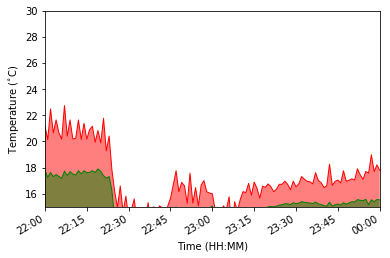

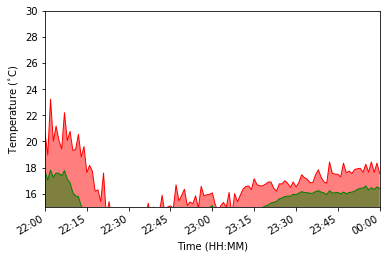

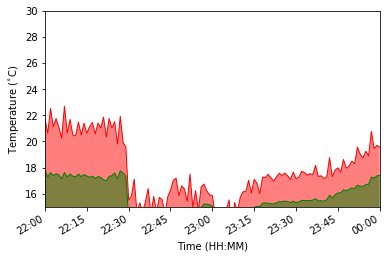

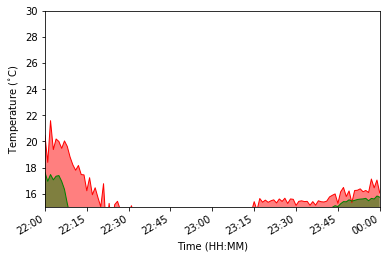

In [171]:
dateformat = '%H:%M' 
formatter = dates.DateFormatter(dateformat)
locator = dates.MinuteLocator(byminute=[0,15,30,45])
minorlocator = None
timelabel = 'Time (HH:MM)'
inittime, timeobjs = dh.getTimeObjs()
plottimes = dates.date2num(timeobjs)
xaxislimits = [plottimes[0], plottimes[-1]]
meteo_T_Td_range = [15., 30.]

T_model = np.array(T_model)
Td_model = np.array(Td_model)

for i, PIPSname in enumerate(ib.dis_name_list):
    #print i
    fig, ax = plt.subplots()
    fields = [T_model[:, i], Td_model[:, i]]
    fieldparamdicts = [PIPSplot.temp_params, PIPSplot.dewpoint_params]
    ax = PIPSplot.plotmeteogram(ax, [plottimes], fields, fieldparamdicts)
    axparamdict1 = {'majorxlocator': locator, 'majorxformatter': formatter,
                    'minorxlocator': minorlocator, 'axeslimits': [xaxislimits, meteo_T_Td_range],
                    'axeslabels': [timelabel, r'Temperature ($^{\circ}$C)']}
    axparamdicts = [axparamdict1]
    ax, = PIPSplot.set_meteogram_axes([ax], axparamdicts)
    #ax.plot(trange, T_model[:, i], color = 'r')
    #ax.set_xlim(tstart, tstop)
    #ax.set_ylim(15.0, 30.0)

In [172]:
# Now read in microphysical information
dp_data_list = []
for time in trange:
    print "Loading time ", time
    timestring = dh.setTime(time)
    dh.setRun(runname, time=time)
    dp_data, consts = dh.loadMicrophysics()
    dp_data_2D = {}
    dp_data_atPIPS = {}
    for key, dat in dp_data.iteritems():
        temp = np.asfortranarray(dat[..., 1].copy())
        dp_data_atPIPS[key] = ndimage.map_coordinates(temp, coord_array, order=1)
    
    dp_data_list.append(dp_data_atPIPS)

Loading time  3600.0
n0rain =  [8000000.]
n0snow =  [3000000.]
n0grpl =  [400000.]
n0hail =  [40000.]
rhoice =  [500.]
rhosnow =  [100.]
rhogrpl =  [400.]
rhohail =  [913.]
ntcloud =  [1.e+09]
alpharain =  [0.]
alphaice =  [0.]
alphasnow =  [0.]
alphagrpl =  [0.]
alphahail =  [0.]
Found Z arrays! Computed shape parameters!
Loading time  3660.0
n0rain =  [8000000.]
n0snow =  [3000000.]
n0grpl =  [400000.]
n0hail =  [40000.]
rhoice =  [500.]
rhosnow =  [100.]
rhogrpl =  [400.]
rhohail =  [913.]
ntcloud =  [1.e+09]
alpharain =  [0.]
alphaice =  [0.]
alphasnow =  [0.]
alphagrpl =  [0.]
alphahail =  [0.]
Found Z arrays! Computed shape parameters!
Loading time  3720.0
n0rain =  [8000000.]
n0snow =  [3000000.]
n0grpl =  [400000.]
n0hail =  [40000.]
rhoice =  [500.]
rhosnow =  [100.]
rhogrpl =  [400.]
rhohail =  [913.]
ntcloud =  [1.e+09]
alpharain =  [0.]
alphaice =  [0.]
alphasnow =  [0.]
alphagrpl =  [0.]
alphahail =  [0.]
Found Z arrays! Computed shape parameters!
Loading time  3780.0
n0ra

Found Z arrays! Computed shape parameters!
Loading time  5160.0
n0rain =  [8000000.]
n0snow =  [3000000.]
n0grpl =  [400000.]
n0hail =  [40000.]
rhoice =  [500.]
rhosnow =  [100.]
rhogrpl =  [400.]
rhohail =  [913.]
ntcloud =  [1.e+09]
alpharain =  [0.]
alphaice =  [0.]
alphasnow =  [0.]
alphagrpl =  [0.]
alphahail =  [0.]
Found Z arrays! Computed shape parameters!
Loading time  5220.0
n0rain =  [8000000.]
n0snow =  [3000000.]
n0grpl =  [400000.]
n0hail =  [40000.]
rhoice =  [500.]
rhosnow =  [100.]
rhogrpl =  [400.]
rhohail =  [913.]
ntcloud =  [1.e+09]
alpharain =  [0.]
alphaice =  [0.]
alphasnow =  [0.]
alphagrpl =  [0.]
alphahail =  [0.]
Found Z arrays! Computed shape parameters!
Loading time  5280.0
n0rain =  [8000000.]
n0snow =  [3000000.]
n0grpl =  [400000.]
n0hail =  [40000.]
rhoice =  [500.]
rhosnow =  [100.]
rhogrpl =  [400.]
rhohail =  [913.]
ntcloud =  [1.e+09]
alpharain =  [0.]
alphaice =  [0.]
alphasnow =  [0.]
alphagrpl =  [0.]
alphahail =  [0.]
Found Z arrays! Computed 

Found Z arrays! Computed shape parameters!
Loading time  6720.0
n0rain =  [8000000.]
n0snow =  [3000000.]
n0grpl =  [400000.]
n0hail =  [40000.]
rhoice =  [500.]
rhosnow =  [100.]
rhogrpl =  [400.]
rhohail =  [913.]
ntcloud =  [1.e+09]
alpharain =  [0.]
alphaice =  [0.]
alphasnow =  [0.]
alphagrpl =  [0.]
alphahail =  [0.]
Found Z arrays! Computed shape parameters!
Loading time  6780.0
n0rain =  [8000000.]
n0snow =  [3000000.]
n0grpl =  [400000.]
n0hail =  [40000.]
rhoice =  [500.]
rhosnow =  [100.]
rhogrpl =  [400.]
rhohail =  [913.]
ntcloud =  [1.e+09]
alpharain =  [0.]
alphaice =  [0.]
alphasnow =  [0.]
alphagrpl =  [0.]
alphahail =  [0.]
Found Z arrays! Computed shape parameters!
Loading time  6840.0
n0rain =  [8000000.]
n0snow =  [3000000.]
n0grpl =  [400000.]
n0hail =  [40000.]
rhoice =  [500.]
rhosnow =  [100.]
rhogrpl =  [400.]
rhohail =  [913.]
ntcloud =  [1.e+09]
alpharain =  [0.]
alphaice =  [0.]
alphasnow =  [0.]
alphagrpl =  [0.]
alphahail =  [0.]
Found Z arrays! Computed 

Found Z arrays! Computed shape parameters!
Loading time  8280.0
n0rain =  [8000000.]
n0snow =  [3000000.]
n0grpl =  [400000.]
n0hail =  [40000.]
rhoice =  [500.]
rhosnow =  [100.]
rhogrpl =  [400.]
rhohail =  [913.]
ntcloud =  [1.e+09]
alpharain =  [0.]
alphaice =  [0.]
alphasnow =  [0.]
alphagrpl =  [0.]
alphahail =  [0.]
Found Z arrays! Computed shape parameters!
Loading time  8340.0
n0rain =  [8000000.]
n0snow =  [3000000.]
n0grpl =  [400000.]
n0hail =  [40000.]
rhoice =  [500.]
rhosnow =  [100.]
rhogrpl =  [400.]
rhohail =  [913.]
ntcloud =  [1.e+09]
alpharain =  [0.]
alphaice =  [0.]
alphasnow =  [0.]
alphagrpl =  [0.]
alphahail =  [0.]
Found Z arrays! Computed shape parameters!
Loading time  8400.0
n0rain =  [8000000.]
n0snow =  [3000000.]
n0grpl =  [400000.]
n0hail =  [40000.]
rhoice =  [500.]
rhosnow =  [100.]
rhogrpl =  [400.]
rhohail =  [913.]
ntcloud =  [1.e+09]
alpharain =  [0.]
alphaice =  [0.]
alphasnow =  [0.]
alphagrpl =  [0.]
alphahail =  [0.]
Found Z arrays! Computed 

Found Z arrays! Computed shape parameters!
Loading time  9840.0
n0rain =  [8000000.]
n0snow =  [3000000.]
n0grpl =  [400000.]
n0hail =  [40000.]
rhoice =  [500.]
rhosnow =  [100.]
rhogrpl =  [400.]
rhohail =  [913.]
ntcloud =  [1.e+09]
alpharain =  [0.]
alphaice =  [0.]
alphasnow =  [0.]
alphagrpl =  [0.]
alphahail =  [0.]
Found Z arrays! Computed shape parameters!
Loading time  9900.0
n0rain =  [8000000.]
n0snow =  [3000000.]
n0grpl =  [400000.]
n0hail =  [40000.]
rhoice =  [500.]
rhosnow =  [100.]
rhogrpl =  [400.]
rhohail =  [913.]
ntcloud =  [1.e+09]
alpharain =  [0.]
alphaice =  [0.]
alphasnow =  [0.]
alphagrpl =  [0.]
alphahail =  [0.]
Found Z arrays! Computed shape parameters!
Loading time  9960.0
n0rain =  [8000000.]
n0snow =  [3000000.]
n0grpl =  [400000.]
n0hail =  [40000.]
rhoice =  [500.]
rhosnow =  [100.]
rhogrpl =  [400.]
rhohail =  [913.]
ntcloud =  [1.e+09]
alpharain =  [0.]
alphaice =  [0.]
alphasnow =  [0.]
alphagrpl =  [0.]
alphahail =  [0.]
Found Z arrays! Computed 

(121, 4)


/Users/dawson29/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:30: RuntimeWarning: divide by zero encountered in log10


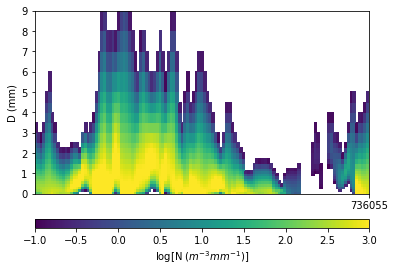

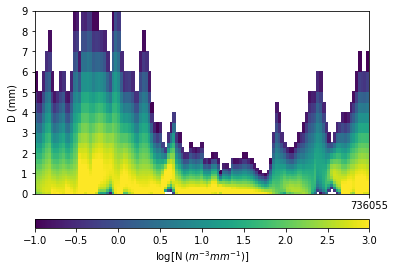

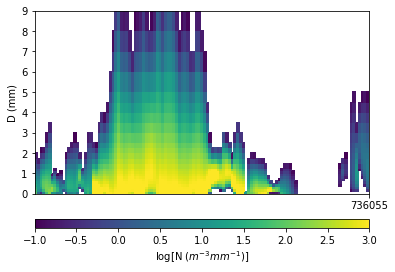

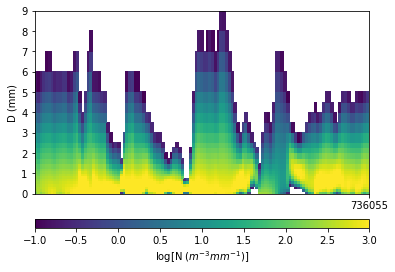

In [173]:
# Now plot the raw model DSD
cr = np.pi/6.
PSDtimestamps_edge = [x - DSD_interval_td for x in timeobjs]
# Add an extra 10 sec for the last time bin boundary
PSDtimestamps_edge.append(PSDtimestamps_edge[-1] + DSD_interval_td)
PSDstarttimes = dates.date2num(PSDtimestamps_edge)

rhoa = np.array([item['rhoa'] for item in dp_data_list])
qr = np.array([item['qr'] for item in dp_data_list])
ntr = np.array([item['ntr'] for item in dp_data_list])
alphar = np.array([item['alphar'] for item in dp_data_list])

N0r,_ = dsd.cal_N0(rhoa, qr/1000., ntr, cr, alphar)
lamdar = dsd.cal_lamda(rhoa, qr/1000., ntr, cr, alphar)

Nc_bin = np.empty((np.size(N0r, axis=0), np.size(D), np.size(N0r, axis=1)))

print N0r.shape

# # print N0r
# # print lamdar
# # print tmpalphar2

# print xeplot.shape


for index,dummy in np.ndenumerate(N0r):
    Nc_bin[index[0],:,index[1]] = 1.e-3*N0r[index]*(D)**alphar[index]*np.exp(-lamdar[index]*(D))
Nc_bin = np.ma.masked_invalid(Nc_bin)
logNc_bin = np.log10(Nc_bin)
logNc_bin = np.ma.masked_where(logNc_bin <= -1.0,logNc_bin)

for i, PIPSname in enumerate(ib.dis_name_list):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    divider = make_axes_locatable(ax)
    C = ax.pcolor(PSDstarttimes,Dl*1000.,logNc_bin[:,:,i].swapaxes(0,1),vmin=-1.0,vmax=3.0)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(base=5.0))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(base=1.0))
    #ax.set_xlim(-30.0,30.0)
    ax.set_ylim(0.0,9.0)
    ax.set_ylabel('D (mm)')
    cax = divider.append_axes("bottom",size="5%",pad=0.35)
    cb = fig.colorbar(C,cax=cax,orientation='horizontal')
    cb.set_label(r'log[N ($m^{-3} mm^{-1}$)]')

# plt.savefig('raw_modelDSD.png',dpi=300)

/Users/dawson29/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in log10


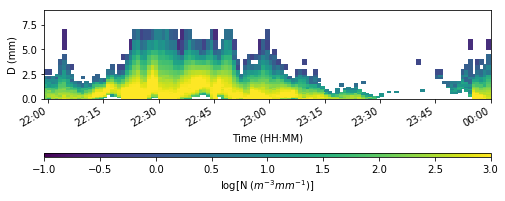

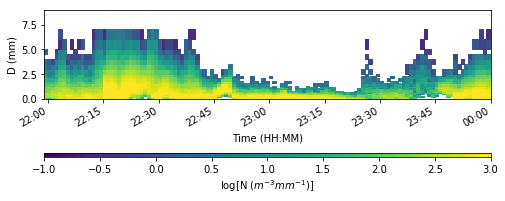

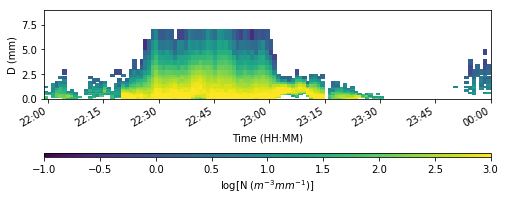

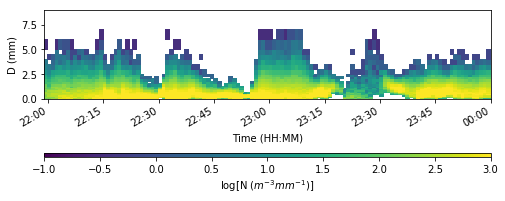

In [174]:
# Now plot the sampled model DSD
Dmax = 8.
Dmax_index = np.searchsorted(Dr, Dmax/1000.)

Nc_bin2 = np.empty((np.size(N0r, axis=0), np.size(D[:Dmax_index+1]), np.size(N0r, axis=1)))
for index,_ in np.ndenumerate(N0r):
    # print index,dp_data_2D['ntr'][index,0]
    positions, diameters, velocities, ND_sample = create_random_gamma_DSD(ntr[index], lamdar[index], 
                                                                          alphar[index], Vtr, sampling_length, 
                                                                          sampling_width, Dl, D, Dr, sampling_interval=60.)
    Nc_bin2[index[0],:,index[1]] = 1.e-3*ND_sample

Nc_bin2 = np.ma.masked_invalid(Nc_bin2)
logNc_bin2 = np.log10(Nc_bin2)
logNc_bin2 = np.ma.masked_where(logNc_bin2 <= -1.0,logNc_bin2)

for i, PIPSname in enumerate(ib.dis_name_list):
    fig = plt.figure(figsize=(8, 3))
    ax = fig.add_subplot(111)
    divider = make_axes_locatable(ax)
    C = ax.pcolor(PSDstarttimes,Dl[:Dmax_index+1]*1000.,logNc_bin2[:,:,i].swapaxes(0,1),vmin=-1.0,vmax=3.0)
    #ax.xaxis.set_major_locator(ticker.MultipleLocator(base=5.0))
    #ax.yaxis.set_major_locator(ticker.MultipleLocator(base=1.0))
    #ax.set_xlim(-30.0,30.0)
    axparamdict1 = {'majorxlocator': locator, 'majorxformatter': formatter,
                    'minorxlocator': minorlocator, 'axeslimits': [None, [0.0, 9.0]],
                    'axeslabels': [timelabel, r'D (mm)']}
    axparamdicts = [axparamdict1]
    ax, = PIPSplot.set_meteogram_axes([ax], axparamdicts)
#     ax.set_ylim(0.0,9.0)
#     ax.set_ylabel('D (mm)')
    cax = divider.append_axes("bottom",size="5%",pad=0.75)
    cb = fig.colorbar(C,cax=cax,orientation='horizontal')
    cb.set_label(r'log[N ($m^{-3} mm^{-1}$)]')
    plt.savefig(PIPSname+'_'+runlabel+'_sampled_model_DSD.png',dpi=300)
# plt.savefig('raw_modelDSD.png',dpi=300)